<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#240b36;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px; color:white; text-align: center"> WELCOME TO MY NOTEBOOK </p>
</div>



# Introduction

> Our Python project aims to automate the classification of X-ray images by leveraging the capabilities of deep learning. This endeavor has the potential to bring significant benefits to both medical professionals and patients. Our objective is to develop a rapid and precise diagnostic tool for the identification of medical disorders from X-ray pictures by utilizing convolutional neural networks and data augmentation techniques. The initiative aims to establish a connection between technology and healthcare, with the objective of optimizing the diagnosis process.

### Table of Contents

* [Step 1. Import Necessary Libraries : ](#h1)

* [Step 2. Define dataset paths and Load Images ](#h2)

* [Step 3: Split the Datasets and Generate the DataFram ](#h3)

* [Step-4: View multiple and single randomly Selected Image](#h4)

* [Step 5. Create train/ val split with training ](#h5)

* [Step 6. Build Augmentation layer ](#h6)

* [Step 7. Creating Pipeline for Transfer Learning](#h7)

* [Step 8. Design and Develop Custom CNN Model](#h8)

* [Step 9. Training and Validating Custom CNN Model](#h9)

* [Step 10. Now Plot the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy](#h10)

* [ Conclusion](#h11)

     
        ## Following this tutorial, you will be able to classify medical image in Python using the transfer learning and popular deep learning tools like TensorFlow and Keras.


# Step-1: Import Necessary Libraries <a class="anchor"  id="h1"></a>

> Import necessary libraries, such as **NumPy, OpenCV, Matplotlib**, and any other relevant packages for image processing and analysis.
> Verify that you have access to any datasets or images you'll be working with.

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [5]:
import random
import os
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline


In [6]:
#Context-Free Grammar (CFG):
class CFG:
    EPOCHS= 50
    BATCH_SIZE= 64
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)

# Step-2: Define dataset paths and Load Images<a class="anchor"  id="h2"></a>

> *You will set up the paths to your dataset and load the X-ray pictures in Step 2. Before you go any further, make sure that your dataset is organized into the right folders. For example, you could have one directory for each class (like "normal" and "disease"), and each directory should contain the X-ray images for that class. Here's a simple example of how to use Python and the OpenCV tool to set dataset paths and load images:*

In [7]:
DATASET_PATH="D:custom\\project\\datasets\\Pneumonia\\"
TRAIN_PATH=  "D:\\custom\\project\\datasets\\Pneumonia\\train\\"
TEST_PATH= "D:\\custom\\project\\datasets\\Pneumonia\\test\\"

In [8]:
#Generate a summary of dataset:

print("DATASET SUMMARY")
print("---------------------------------------")

for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
print('\n---------------------------------------')
    

DATASET SUMMARY
---------------------------------------
there are 2 directories and 0 images in D:\Data\
there are 3 directories and 0 images in D:\Data\test
there are 0 directories and 116 images in D:\Data\test\COVID19
there are 0 directories and 317 images in D:\Data\test\NORMAL
there are 0 directories and 855 images in D:\Data\test\PNEUMONIA
there are 3 directories and 0 images in D:\Data\train
there are 0 directories and 460 images in D:\Data\train\COVID19
there are 0 directories and 1266 images in D:\Data\train\NORMAL
there are 0 directories and 3418 images in D:\Data\train\PNEUMONIA

---------------------------------------


In [9]:
train_images= glob.glob(f'{TRAIN_PATH}**/*.jpg')
test_images= glob.glob(f'{TEST_PATH}**/*.jpg')

In [10]:
train_size= len(train_images)
test_size= len(test_images)

total= train_size+test_size
print(f'Total: {total}')

Total: 6432


# Step-3: Split the Datasets and Generate the DataFram<a class="anchor"  id="h3"></a>

> *In Step 3, you will divide your dataset into training, validation, and test sets. You will also make a DataFrame or other data structure to help you organize and handle your data. For this, you can use Python tools like pandas and scikit-learn. How to do it:*

In [11]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]
def build_df(image_paths, labels):
    df= pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'COVID19' else 1 if row.label == 'NORMAL' else 2, axis=1)


    return df.sample(frac=1, random_state= CFG.SEED).reset_index(drop=True)

In [12]:
#  Build the datafram

train_df= build_df(train_images, generate_labels(train_images))
test_df= build_df(test_images, generate_labels(test_images))

In [13]:
# View frist some sample in training and testing set 

train_df.head(5)

,image_path,label,label_encoded
0,D:\Data\train\PNEUMONIA\PNEUMONIA(829).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(829).jpg,2
1,D:\Data\train\PNEUMONIA\PNEUMONIA(2424).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(2424).jpg,2
2,D:\Data\train\PNEUMONIA\PNEUMONIA(1452).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(1452).jpg,2
3,D:\Data\train\PNEUMONIA\PNEUMONIA(52).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(52).jpg,2
4,D:\Data\train\NORMAL\NORMAL(1147).jpg,D:\Data\train\NORMAL\NORMAL(1147).jpg,2


In [14]:
def _load(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image to a uint8 tensor
    image = tf.io.decode_image(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)
    return image


# Step-4: View multiple and single randomly Selected Image<a class="anchor"  id="h4"></a>

> *In Step 4, you can add the ability to view both a single X-ray picture and a group of randomly chosen images. You can use Python and tools like Matplotlib and OpenCV to do this. This step can be done in this way:*

In [15]:
 def view_sample(image, label, color_map='rgb',fig_size=(6,4)):
    plt.figure(figsize=fig_size)
    if color_map== 'rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap= color_map)
    plt.title(f'label:{label}', fontsize= 16)
    return

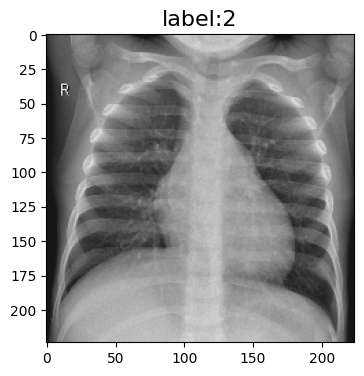

In [16]:
#select random sample from train_df
idx= random.sample(train_df.index.to_list(),1)[0]
#load the random sample and label
#sample_image, sample_label= _load(train_df.image_path[idx])
sample_image = _load(train_df.image_path[idx])
sample_label = train_df.label_encoded[idx]

#view the random sample colormap= gray
view_sample(sample_image, sample_label, color_map='gray')

In [17]:
# View multiple samples:
def view_multiple_samples(df,sample_loader, count=10, color_map='rgb', fig_size=(14,10)):
    rows= count//5
    if rows%5>0:
        rows+=1
    idx= random.sample(df.index.to_list(), count)
    fig= plt.figure(figsize=fig_size)
    
    for colum,_ in enumerate(idx):
        plt.subplot(rows,5,colum+1)
        plt.title(f'Label: {df.label[_]}')
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)
    return

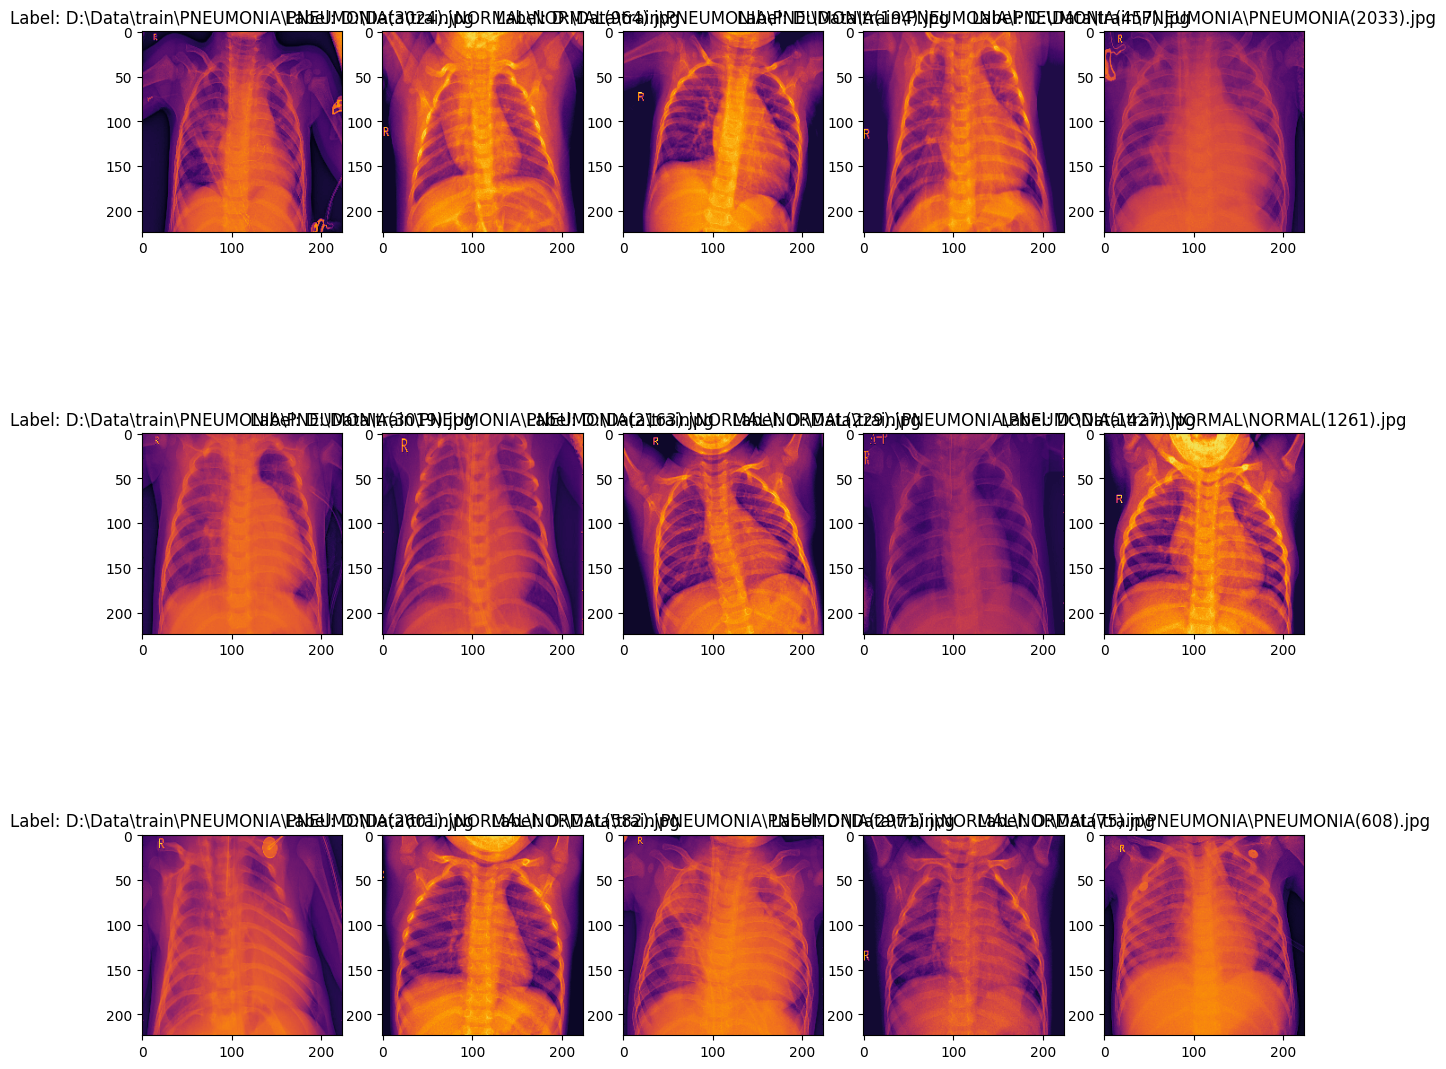

In [18]:
view_multiple_samples(train_df, _load, count=15, color_map='inferno', fig_size=(15,20))

# Step-5: Create train/ val split with Training<a class="anchor"  id="h5"></a>

> *In Step 5, you will split the data into training and validation sets. This is an important step in building a machine-learning model. This split lets you use one set of data to train your model (the training set) and a different set to test how well it works (the validation set). Here's how to use Python to make the split:*


In [19]:
#create train/ val split with training
train_split_idx, val_split_idx,_,_= train_test_split(train_df.index,
                                                    train_df.label_encoded,
                                                    test_size= 0.15,
                                                    stratify=train_df.label_encoded,
                                                    random_state= CFG.SEED)

In [20]:
#Get new training and validation data

train_new_df= train_df.iloc[train_split_idx].reset_index(drop=True)
val_df= train_df.iloc[val_split_idx].reset_index(drop=True)
#view shape
train_new_df.shape, val_df.shape
train_new_df

,image_path,label,label_encoded
0,D:\Data\train\PNEUMONIA\PNEUMONIA(1562).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(1562).jpg,2
1,D:\Data\train\PNEUMONIA\PNEUMONIA(1129).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(1129).jpg,2
2,D:\Data\train\PNEUMONIA\PNEUMONIA(2769).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(2769).jpg,2
3,D:\Data\train\PNEUMONIA\PNEUMONIA(3148).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(3148).jpg,2
4,D:\Data\train\COVID19\COVID19(183).jpg,D:\Data\train\COVID19\COVID19(183).jpg,2
...,...,...,...
4367,D:\Data\train\PNEUMONIA\PNEUMONIA(3289).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(3289).jpg,2
4368,D:\Data\train\PNEUMONIA\PNEUMONIA(760).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(760).jpg,2
4369,D:\Data\train\COVID19\COVID19(412).jpg,D:\Data\train\COVID19\COVID19(412).jpg,2
4370,D:\Data\train\NORMAL\NORMAL(1207).jpg,D:\Data\train\NORMAL\NORMAL(1207).jpg,2


# Step-6: Build an Augmentation layer<a class="anchor"  id="h6"></a>

> *You can use data augmentation methods on your X-ray image data by building an augmentation layer in Step 6. Adding more data is an important part of deep learning, especially when it comes to picture classification tasks, because it helps the model generalize better. To make this layer, you can use tools like TensorFlow (Keras) or PyTorch. These examples show how to use both frameworks:*

In [21]:
#Build Augmentation layer
augmentation_layer= Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical',seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01,0.1),width_factor=(-0.1,0.1),seed=CFG.TF_SEED)
],name= 'augmentation_layer')

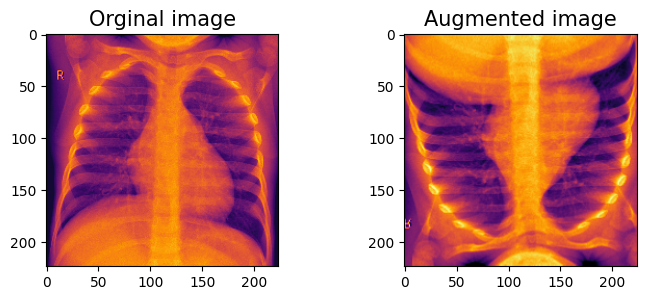

In [22]:
# Show inferno Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='inferno')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='inferno')


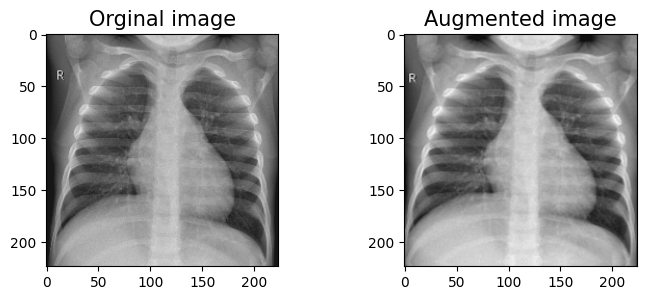

In [23]:
# Show Gray Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='gray')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='gray')


# Step-7: Creating Pipeline for Transfer Learning<a class="anchor"  id="h7"></a>

> *In Step 7, you will use a model that has already been taught to set up a pipeline for transfer learning. Transfer learning lets you use a neural network that has already been trained and adapt it to do what you do better. Using well-known deep learning tools like TensorFlow (Keras) and PyTorch, you can build the pipeline by following these steps:*

In [24]:
train_new_df

,image_path,label,label_encoded
0,D:\Data\train\PNEUMONIA\PNEUMONIA(1562).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(1562).jpg,2
1,D:\Data\train\PNEUMONIA\PNEUMONIA(1129).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(1129).jpg,2
2,D:\Data\train\PNEUMONIA\PNEUMONIA(2769).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(2769).jpg,2
3,D:\Data\train\PNEUMONIA\PNEUMONIA(3148).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(3148).jpg,2
4,D:\Data\train\COVID19\COVID19(183).jpg,D:\Data\train\COVID19\COVID19(183).jpg,2
...,...,...,...
4367,D:\Data\train\PNEUMONIA\PNEUMONIA(3289).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(3289).jpg,2
4368,D:\Data\train\PNEUMONIA\PNEUMONIA(760).jpg,D:\Data\train\PNEUMONIA\PNEUMONIA(760).jpg,2
4369,D:\Data\train\COVID19\COVID19(412).jpg,D:\Data\train\COVID19\COVID19(412).jpg,2
4370,D:\Data\train\NORMAL\NORMAL(1207).jpg,D:\Data\train\NORMAL\NORMAL(1207).jpg,2


In [25]:
def encode_labels(labels,encode_depth=3):
    return tf.one_hot(labels,depth=encode_depth).numpy()
def create_pipeline(df,load_function,augment=False,batch_size=32,shuffle=False,cache=None,prefetch=False):
    #get image path and labels from data_frame
    image_paths= df.image_path
    image_labels= encode_labels(df.label_encoded)
    AUTOTUNE= tf.data.AUTOTUNE
    #Create dataset with raw data from data frame
    ds= tf.data.Dataset.from_tensor_slices((image_paths,image_labels))
    #map augmentation layer and load function to dataset input if augment is true
    if augment:
        ds=ds.map(lambda x,y: (augmentation_layer(load_function(x)),y),num_parallel_calls= AUTOTUNE)
    else:
        ds= ds.map(lambda x,y: (load_function(x),y),num_parallel_calls= AUTOTUNE)
    #Applying shuffing based on condion
    if shuffle:
        ds= ds.shuffle(buffer_size=1000)
    #applying batching
    ds= ds.batch(batch_size)
    #applying caching based on condion
    if cache!=None:
        ds= ds.cache(cache)
    if prefetch:
        ds= ds.prefetch(buffer_size= AUTOTUNE)
    return ds


In [26]:
def _load(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image to a uint8 tensor
    image = tf.io.decode_image(image, channels=3)
    # Ensure the image has a known shape
    image.set_shape([CFG.HEIGHT, CFG.WIDTH, 3])
    # Resize the image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)
    return image


In [27]:
#Creating Training Pipeline
train_ds= create_pipeline(train_new_df,_load,
                         augment= True,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= True)

In [28]:
#Creating Test Pipeline
test_ds= create_pipeline(test_df,_load,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [29]:
#Creating Validation Pipeline
val_ds= create_pipeline(val_df,_load,
                         
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [30]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Step-8: Design and Develop Custom CNN Model <a class="anchor"  id="h8"></a>

> *In Step 8, you will create a unique Convolutional Neural Network (CNN) model for your X-ray picture categorization challenge. This customized CNN model will be developed from the bottom up without using a pre-trained model. Here's how to create your own CNN model with popular deep learning frameworks like TensorFlow (Keras) and PyTorch:*

In [31]:
def cnn_model():
    initializer= tf.keras.initializers.GlorotNormal()
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        
        
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer), 
    ], name='cnn_sequential_model')
    return cnn_sequential


In [32]:
def cnn_model16():
    initializer= tf.keras.initializers.GlorotNormal()
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        
        
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
         layers.Conv2D(4,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(4,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer), 
    ], name='cnn_sequential_model')
    return cnn_sequential


In [33]:
# Create an instance of the model
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 8)       1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 8)         0         
 g2D)                                         

# Step-9: Training and Validating Custom CNN Model <a class="anchor"  id="h9"></a>

> *In Step 9, you will train and test your unique Convolutional Neural Network (CNN) model for classifying X-ray images. Training and validating the model are very important parts of the model creation process. I'll show you how to use popular deep learning tools like TensorFlow (Keras) and PyTorch to train and test your model below:*

In [34]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling= True):
    model_history={}
    if tf_valid_data!=None:
        model_history= model.fit(tf_train_data,
                                 epochs= num_epochs,
                                 validation_data= tf_valid_data,
                                 validation_steps= int(len(tf_valid_data)),
                                 callbacks= callbacks_list,
                                 shuffle= shuffling
                                )
    if tf_valid_data==None:
        model_history= model.fit(tf_train_data,
                                 epochs= num_epochs,
                                 callbacks= callbacks_list,
                                 shuffle= shuffling
                                )
    return model_history


In [35]:
early_stopping_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=5,
                                                         verbose=1,
                                                         restore_best_weights=True)

reduce_lr_callback= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        patience=3,
                                                        factor=0.1,
                                                        verbose=1)

CALLBACKS=[early_stopping_callback, reduce_lr_callback]
METRICS=['accuracy']


In [36]:
tf.random.set_seed(CFG.SEED)
model_cnn.compile(loss='categorical_crossentropy',
                 optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                 metrics=METRICS)

print(f'training{model_cnn.name}.')
print(f'Train On: {len(train_new_df)} samples, validate On: {len(val_df)} samples.')
print('----------------------------------------------------------')
cnn_history= train_model(model_cnn, CFG.EPOCHS, CALLBACKS, train_ds, val_ds, shuffling=True)

model_cnn.save("C:\\Users\\vaibh\\Music\\pxray.h5")

trainingcnn_sequential_model.
Train On: 4372 samples, validate On: 772 samples.
----------------------------------------------------------
Epoch 1/50
69/69 [==============================] - 70s 1s/step - loss: 0.7030 - accuracy: 0.9892 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/50
69/69 [==============================] - 75s 1s/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0014 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/50
69/69 [==============================] - 77s 1s/step - loss: 5.9817e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/50
69/69 [==============================] - 79s 1s/step - loss: 6.2681e-04 - accuracy: 1.0000 - val_loss: 9.3716e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/50
69/69 [==============================] - 71s 1s/step - loss: 5.0549e-04 - accuracy: 0.9998 - val_loss: 7.6155e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/50
69/69 [==============================] - 69s 

In [37]:
cnn_evaluatiion= model_cnn.evaluate(test_ds)

21/21 [==============================] - 5s 251ms/step - loss: 5.7624e-06 - accuracy: 1.0000


In [38]:
# Model loading
from tensorflow.keras.models import load_model


model=load_model("C:\\Users\\vaibh\\Music\\pxray.h5")

# Now Predictions for random image

In [41]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input


img= image.load_img("C:\\Users\\vaibh\\Downloads\\Data\\test\\COVID19\\COVID19(460).jpg",target_size=(224,224))

x= image.img_to_array(img)
x=x/255
x= np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
img_data.shape
preds= model.predict(x)
preds= np.argmax(preds, axis=1)

if preds==0:
    preds="The image is Covid19"
elif preds==1:
    preds="The image is NORMAL"
else:
    preds="The image is Pneumonia"
print(preds)

1/1 [==============================] - 0s 95ms/step
The image is Pneumonia


In [42]:
preds

'The image is Pneumonia'

In [43]:
cnn_test_probabilities=model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions= tf.argmax(cnn_test_probabilities, axis=1)

21/21 [==============================] - 5s 247ms/step


In [44]:
cnn_test_probabilities

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

# Step-10:  Now Plot the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy <a class="anchor"  id="h10"></a>

> *Step 10 lets you map the training loss, validation loss, training accuracy, and validation accuracy to see how well your custom CNN model is doing while it is being trained. To make these plots, you can use Python tools like Matplotlib. Here are some examples of how to make these plots with TensorFlow (Keras) and PyTorch, two famous deep learning frameworks:*

In [45]:
import numpy as np

def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])
    
    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])
    
    epochs= range(len(history.history['loss']))
    
    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
    
    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')
    
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)
    
    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)
    
    ax1.legend()
    
    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')
    
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)
    
    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)
    
    ax2.legend()
    

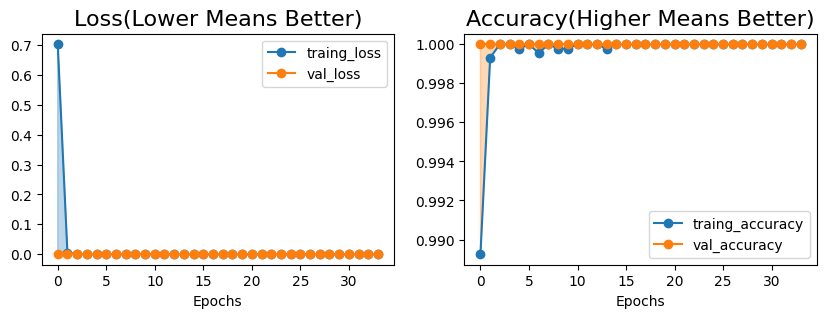

In [46]:
plot_training_curves(cnn_history)

# Conclusion <a class="anchor"  id="h11"></a>

> Finally, whether you utilized a pre-trained transfer learning model or a custom CNN, you've built and trained a deep learning model for X-ray picture categorization. Your main steps are summarized here:

* Preparing the dataset:

Classify your X-ray images ("normal" and "disease").
Get the dataset and prepare the photos.

* Splitting Data:

Divide your dataset into training, validation, and test sets to evaluate the model.

* Optional data augmentation:

Expand the training dataset and improve model generalization with data augmentation.

* Choose a Model:

Choose a pre-trained transfer learning model or a custom CNN for classification.

* Model Training:

Train the chosen model on the training dataset and evaluate it on the validation set.

* Evaluation:

Test the model's accuracy and generalization on another dataset.

* Plotting Results:

1. Visualize training and validation loss and accuracy to analyze model learning.
   You implemented these stages using TensorFlow (Keras) and PyTorch. After deployment, your model can  classify X-ray pictures into important categories to aid medical diagnosis and assessment.

1. Fine-tuning your model, improving hyperparameters, or integrating it into a medical imaging application may improve your project. Data quality, model architecture, and training will determine the success of your X-ray image classification model. Your model must be monitored and updated to be accurate and reliable in real-world situations.